In [1]:
'''
Editor: @Hyunhomo
Reference: https://github.com/TobiasGlaubach/python-ml-turbofan
'''

## Import libraries in python
import os
import pandas as pd
import padasip as pa
# pa.filters.FilterRLS(n)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline



In [2]:

### Data load (use only FD001 first)
## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']


## Read csv file to pandas dataframe
train_FD001 = pd.read_csv('CMAPSSData/train_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
test_FD001 = pd.read_csv('CMAPSSData/test_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
RUL_FD001 = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep= ' ', header=None, 
                          names=col_rul, index_col=False)

## Calculate RUL and append to train data
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in train_FD001['unit_nr'].unique():
    mapper[unit_nr] = train_FD001['cycles'].loc[train_FD001['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
train_FD001['RUL'] = train_FD001['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD001['cycles']


## Excluse columns which only have NaN as value
# nan_cols = ['sensor_{0:02d}'.format(s + 22) for s in range(5)]
cols_nan = train_FD001.columns[train_FD001.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')
cols_const = [ col for col in train_FD001.columns if len(train_FD001[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')


train_FD001 = train_FD001.drop(columns=cols_const + cols_nan)
test_FD001 = test_FD001.drop(columns=cols_const + cols_nan)

## Check loaded data
print (train_FD001)
print (test_FD001)
print (RUL_FD001)




Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

       unit_nr  cycles    os_1    os_2  sensor_02  sensor_03  sensor_04  \
0            1       1 -0.0007 -0.0004     641.82    1589.70    1400.60   
1            1       2  0.0019 -0.0003     642.15    1591.82    1403.14   
2            1       3 -0.0043  0.0003     642.35    1587.99    1404.20   
3            1       4  0.0007  0.0000     642.35    1582.79    1401.87   
4            1       5 -0.0019 -0.0002     642.37    1582.85    1406.22   
...        ...     ...     ...     ...        ...        ...        ...   
20626      100     196 -0.0004 -0.0003     643.49    1597.98    1428.63   
20627      100     197 -0.0016 -0.0005     643.54    1604.50    1433.58   
20628      100     198  0.0004  0.000

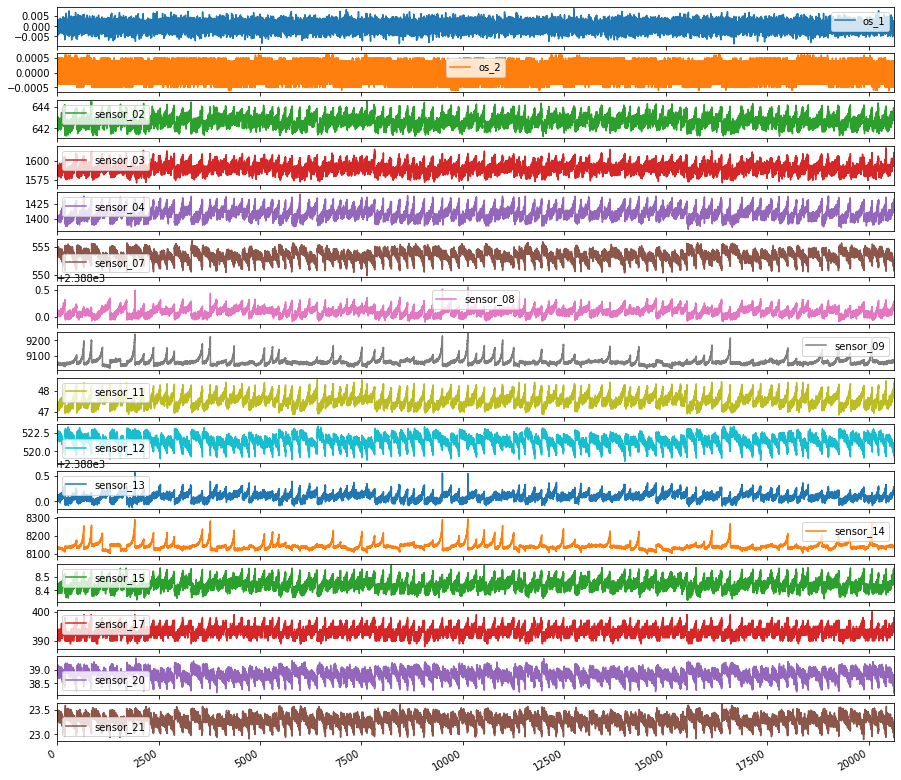

In [3]:
## Plot sensor measurements (time series data) / without normalization
cols_features = [c for c in train_FD001.columns if c.startswith('o') or c.startswith('s')]
t = pd.DataFrame(train_FD001[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))




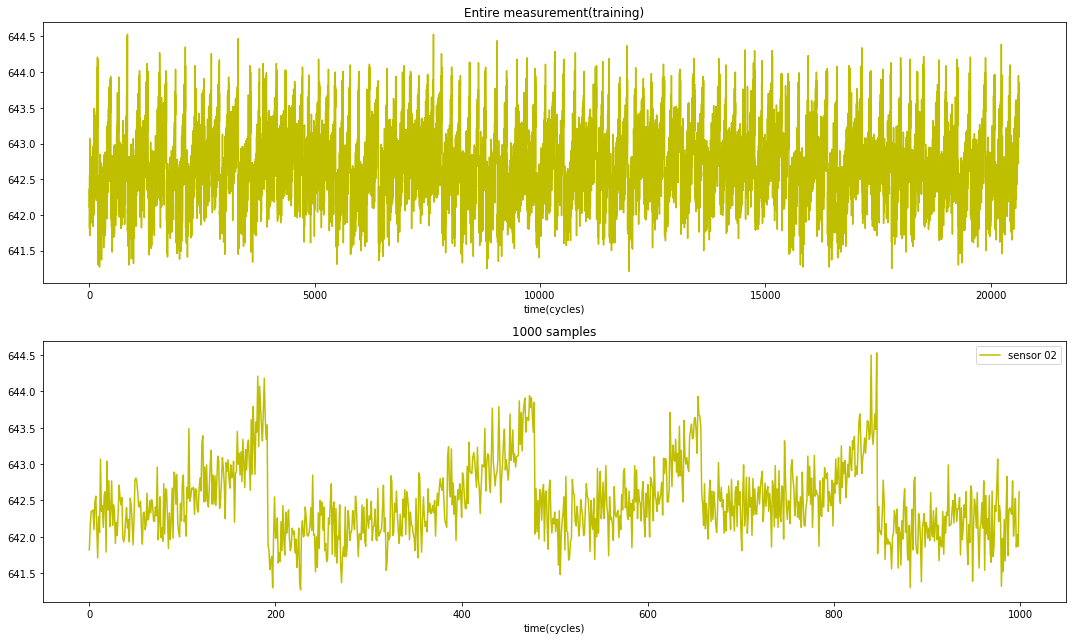

In [4]:
### Prediction error estimation (Anomaly score) with RLS
## Only consider sensor 02
# Assign a time series to numpy array
sensor_02_ts = train_FD001['sensor_02']

# show a time series
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Entire measurement(training)");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts,"y", label="sensor 02")
plt.subplot(212);plt.title("1000 samples");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts[:1000],"y", label="sensor 02")
plt.legend(); plt.tight_layout(); plt.show()


In [5]:
## Generate array of input sequences and target value(sensor measurement)
# sequence length 
sequence_length = 100
pred_length = 1

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print ("data_matrix", data_matrix)
#     print (" data_matrix.shape",  data_matrix.shape)
#     print ("data_matrix.shape[0]", data_matrix.shape[0])
    num_elements = data_matrix.shape[0]
#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements - seq_length - pred_length), range(seq_length, num_elements - pred_length)):
        yield data_matrix[start:stop, :]


# pick the feature columns
sensor_dataframe = train_FD001.drop(columns=['unit_nr','cycles','os_1','os_2','RUL'])
sequence_cols = sensor_dataframe.columns.values.tolist()
print (sequence_cols)

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_FD001[train_FD001['unit_nr'] == id], sequence_length, sequence_cols))
           for id in train_FD001['unit_nr'].unique())

# generate sequences and convert to numpy array
seq_array  = np.concatenate(list(seq_gen))
# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array)
print(seq_array.shape)




['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
[[[ 641.82   1589.7    1400.6    ...  392.       39.06     23.419 ]
  [ 642.15   1591.82   1403.14   ...  392.       39.       23.4236]
  [ 642.35   1587.99   1404.2    ...  390.       38.95     23.3442]
  ...
  [ 642.     1591.11   1404.56   ...  391.       38.96     23.2554]
  [ 642.46   1592.73   1406.13   ...  393.       38.82     23.2323]
  [ 642.22   1589.63   1411.35   ...  392.       38.93     23.409 ]]

 [[ 642.15   1591.82   1403.14   ...  392.       39.       23.4236]
  [ 642.35   1587.99   1404.2    ...  390.       38.95     23.3442]
  [ 642.35   1582.79   1401.87   ...  392.       38.88     23.3739]
  ...
  [ 642.46   1592.73   1406.13   ...  393.       38.82     23.2323]
  [ 642.22   1589.63   1411.35   ...  392.       38.93     23.409 ]
  [ 642.75   1584.18   1403.41   ...  391.       38.75 

In [6]:
## function to generate target value



def gen_target(id_df, seq_length, pred_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print (" data_matrix.shape",  data_matrix.shape)
    num_elements = data_matrix.shape[0]

#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(seq_length, num_elements  -pred_length), range(seq_length + pred_length , num_elements )):
        yield data_matrix[start:stop, :]
        
# def gen_target(id_df, seq_length, pred_length, seq_cols):
#     """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
#     we need to drop those which are below the window-length. An alternative would be to pad sequences so that
#     we can use shorter ones """
#     # for one id I put all the rows in a single matrix
#     data_matrix = id_df[seq_cols].values
#     print (" data_matrix.shape",  data_matrix.shape)
#     num_elements = data_matrix.shape[0]
#     dummy = data_matrix[num_elements-1,:]
# #     print ("dummy",dummy.shape)
# #     print ("dummy", dummy)
#     data_matrix_appended = np.vstack([data_matrix,dummy])
#     print (data_matrix_appended.shape)
# #     print ("num_elements", num_elements)
#     # Iterate over two lists in parallel.
#     # For example id1 have 192 rows and sequence_length is equal to 50
#     # so zip iterate over two following list of numbers (0,112),(50,192)
#     # 0 50 -> from row 0 to row 50
#     # 1 51 -> from row 1 to row 51
#     # 2 52 -> from row 2 to row 52
#     # ...
#     # 111 191 -> from row 111 to 191
#     for start, stop in zip(range(seq_length, num_elements ), range(seq_length + pred_length, num_elements + pred_length )):
#         yield data_matrix_appended[start:stop, :]        

# generator for the sequences
# transform each id of the train dataset in a sequence
target_seq_gen = (list(gen_target(train_FD001[train_FD001['unit_nr'] == id], sequence_length, pred_length, sequence_cols))
           for id in train_FD001['unit_nr'].unique())

# print ("target_seq_gen", target_seq_gen)
# generate sequences and convert to numpy array
target_seq_array  = np.concatenate(list(target_seq_gen))
# target_seq_array = np.concatenate(list(target_seq_gen)).astype(np.float32)
print(target_seq_array)
print(target_seq_array.shape)

'''
last target value should be replicated 
'''


[[[ 642.75   1584.18   1403.41   ...  391.       38.75     23.4149]]

 [[ 642.85   1589.11   1403.42   ...  393.       38.94     23.3653]]

 [[ 642.21   1581.27   1403.21   ...  392.       38.69     23.4289]]

 ...

 [[ 643.54   1604.5    1433.58   ...  395.       38.3      23.1594]]

 [[ 643.42   1602.46   1428.18   ...  398.       38.44     22.9333]]

 [[ 643.23   1605.26   1426.53   ...  395.       38.29     23.064 ]]]
(10531, 1, 14)


'\nlast target value should be replicated \n'

In [7]:
## function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements- pred_length, :]


# generate RUL labels
label_gen = [gen_labels(train_FD001[train_FD001['unit_nr'] == id], sequence_length, ['RUL'])
             for id in train_FD001['unit_nr'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(10531, 1)

sensor_02 input data shape:  (10531, 100)
sensor_02 target measurement shape:  (10531, 1)
RUL array shape:  (10531, 1)


/home/hyunhomo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


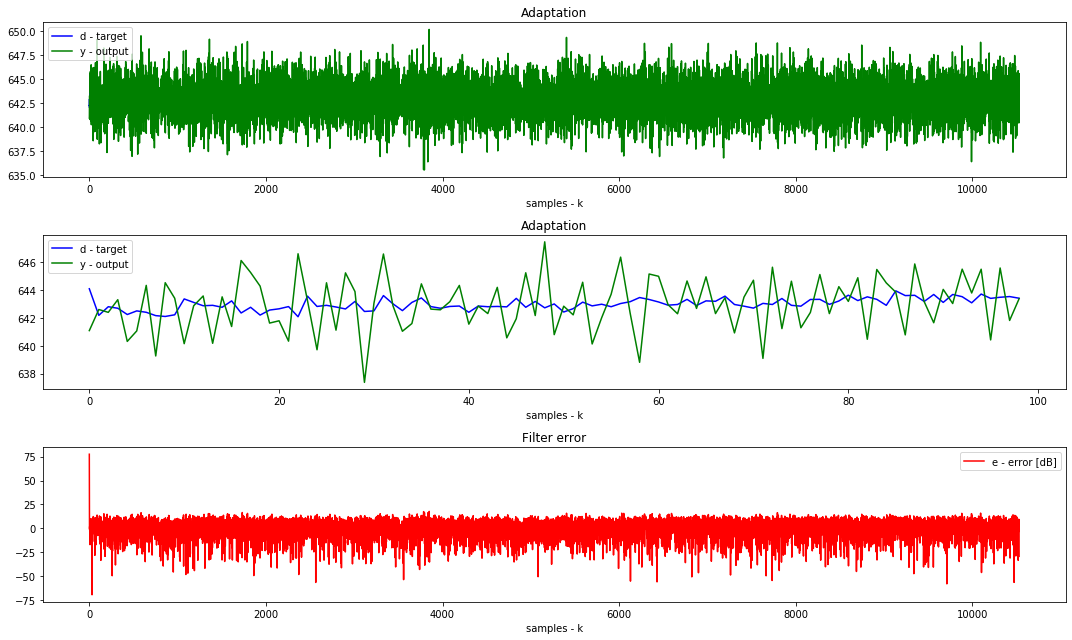

In [8]:
### Prediction error estimation with RLS
## Check data shape (last instance of each unit is excluded)
print ("sensor_02 input data shape: " , seq_array[:,:,0].shape)
print ("sensor_02 target measurement shape: ", target_seq_array[:,:,0].shape)
print ("RUL array shape: ", label_array.shape)


## An example how to filter data measured in real-time
# these two function supplement your online measurment

s2_input_array = seq_array[:,:,0]
s2_target_array = target_seq_array[:,:,0]

N = seq_array.shape[0]
log_d = np.zeros(N)
log_y = np.zeros(N)
filt = pa.filters.FilterRLS(sequence_length, mu=0.5)
for k in range(N-1):
    # measure input
#     print ("k",k)
    x = s2_input_array[k]
#     print (x)
#     print (x.shape)
    # predict new value
    y = filt.predict(x)
    # do the important stuff with prediction output
    pass    
    # measure output
    d = s2_target_array[k]
#     print ("d", d)
#     print ("y", y)
    # update filter
    filt.adapt(d, x)
    # log values
    log_d[k] = d
    log_y[k] = y
    
### show results
plt.figure(figsize=(15,9))
plt.subplot(311);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(log_d[1:-1],"b", label="d - target")
plt.plot(log_y[1:-1],"g", label="y - output");plt.legend()
plt.subplot(312);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(log_d[-100:-1],"b", label="d - target")
plt.plot(log_y[-100:-1],"g", label="y - output");plt.legend()
plt.subplot(313);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10((log_d-log_y)**2),"r", label="e - error [dB]")
plt.legend(); plt.tight_layout(); plt.show()